In [10]:
import os
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [11]:
with zipfile.ZipFile("test1.zip",'r') as z:
    z.extractall(".")
    
with zipfile.ZipFile("train.zip",'r') as z:
    z.extractall(".")

In [12]:
files = os.listdir("train")
classes = ["cat", "dog"]

In [13]:
import shutil

os.makedirs("train/cat", exist_ok=True)
os.makedirs("train/dog", exist_ok=True)

for file in files:
    if file.startswith(classes[0]):
        shutil.move(f"train/{file}", 
                    f"train/cat/{file}")
    else:
        shutil.move(f"train/{file}", 
                    f"train/dog/{file}")

In [14]:
datagenAug = ImageDataGenerator(
    rotation_range=90,
    zoom_range=0.15,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.2
)

trainGen = datagenAug.flow_from_directory(
    "train", classes=classes,
    target_size=(224, 224), class_mode="categorical",
    batch_size=32, subset="training")

testGen = datagenAug.flow_from_directory(
    "train", classes=classes,
    target_size=(224, 224), class_mode="categorical",
    batch_size=32, subset="validation")

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [15]:
vgg_model = VGG16(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))

for layer in vgg_model.layers[:-1]:
    layer.trainable = False
    
head = vgg_model.output
flatten = Flatten()(head)
fc = Dense(512, activation='relu')(flatten)
output = Dense(len(trainGen.class_indices), activation="softmax")(fc)

model = Model(inputs=vgg_model.input, outputs=output)

In [16]:
opt = Adam(learning_rate=1e-4)
model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"])

In [17]:
checkpoint = ModelCheckpoint("vgg.h5", monitor='accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq=1)
early = EarlyStopping(monitor='accuracy', min_delta=0, patience=100, verbose=1, mode='auto')

In [18]:
hist = model.fit(
    trainGen, steps_per_epoch=trainGen.samples // 32,
	validation_data=testGen, validation_steps=testGen.samples // 32,
	epochs=5, callbacks=[checkpoint, early])

Epoch 1/5

Epoch 1: accuracy improved from -inf to 0.53125, saving model to vgg.h5
  1/625 [..............................] - ETA: 42:22 - loss: 6.0368 - accuracy: 0.5312
Epoch 1: accuracy improved from 0.53125 to 0.59375, saving model to vgg.h5
  2/625 [..............................] - ETA: 22:03 - loss: 10.5466 - accuracy: 0.5938
Epoch 1: accuracy did not improve from 0.59375
  3/625 [..............................] - ETA: 11:43 - loss: 11.0881 - accuracy: 0.5729
Epoch 1: accuracy did not improve from 0.59375
  4/625 [..............................] - ETA: 9:41 - loss: 10.6364 - accuracy: 0.5625 
Epoch 1: accuracy did not improve from 0.59375
  5/625 [..............................] - ETA: 8:35 - loss: 10.6544 - accuracy: 0.5750
Epoch 1: accuracy did not improve from 0.59375
  6/625 [..............................] - ETA: 7:58 - loss: 10.2080 - accuracy: 0.5677
Epoch 1: accuracy did not improve from 0.59375
  7/625 [..............................] - ETA: 7:37 - loss: 9.7472 - accura

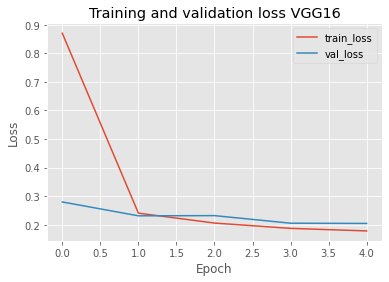

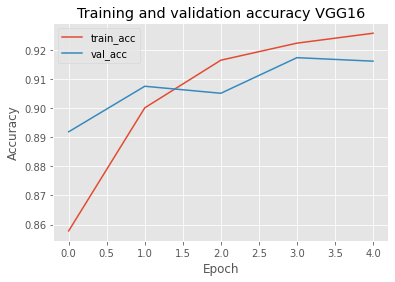

In [21]:
N = np.arange(0, 5)

plt.style.use("ggplot")
plt.figure()
plt.plot(N, hist.history["loss"], label="train_loss")
plt.plot(N, hist.history["val_loss"], label="val_loss")
plt.title("Training and validation loss VGG16")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.savefig("vgg_losses.png")
plt.legend()

plt.figure()
plt.plot(N, hist.history["accuracy"], label="train_acc")
plt.plot(N, hist.history["val_accuracy"], label="val_acc")
plt.title("Training and validation accuracy VGG16")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.savefig("vgg_accuracy.png")
plt.legend()

plt.show()

In [22]:
import cv2

predictions = list()
for path in testGen.filepaths:
    image = cv2.imread(path)
    image = cv2.resize(image, (224, 224))
    image = np.expand_dims(image, axis=0)
    preds = model.predict(image)
    predictions.append(preds.argmax(axis=1))

print(classification_report(testGen.classes,
	predictions, target_names=testGen.class_indices, digits=3))

1/1 [==============================] - 0s 31ms/step
              precision    recall  f1-score   support

         cat      0.980     0.948     0.964      2500
         dog      0.950     0.980     0.965      2500

    accuracy                          0.964      5000
   macro avg      0.965     0.964     0.964      5000
weighted avg      0.965     0.964     0.964      5000



              precision    recall  f1-score   support

         cat      0.980     0.948     0.964      2500
         dog      0.950     0.980     0.965      2500

    accuracy                          0.964      5000
   macro avg      0.965     0.964     0.964      5000
weighted avg      0.965     0.964     0.964      5000



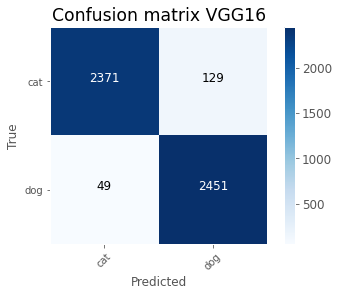

In [23]:
import itertools

print(classification_report(testGen.classes,
	predictions, target_names=testGen.class_indices, digits=3))

plt.style.use("ggplot")
plt.grid(False)
plt.rcParams["figure.figsize"] = (8,6)
font = {'size' : 12}
plt.rc('font', **font)

cm = confusion_matrix(testGen.classes, predictions)

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(testGen.class_indices))

plt.xticks(tick_marks, testGen.class_indices, rotation=45)
plt.yticks(tick_marks, testGen.class_indices)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion matrix VGG16')
plt.savefig('vgg_confusion_matrix.png')
plt.show()

In [33]:
import cv2

testFiles = os.listdir("test1")
id = []
predictions = []

for file in testFiles:
    id.append(file.split('.')[0])
    
    img = cv2.imread(f"test1/{file}")
    img = cv2.resize(img, (224, 224))
    img = img.reshape(-1, 224, 224, 3)
    
    pred = model.predict(img).argmax(axis=1)
    predictions.append(classes[pred[0]])

df = pd.DataFrame({'Id': id, 'Predictions': predictions})
df.to_csv('submission.csv', index=False)

1/1 [==============================] - 0s 174ms/step
